In [ ]:
# Initialize drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Move to Google Drive 
%cd drive
%cd 'My Drive'
%cd 'MSc Stats Dissertation'

/content/drive
/content/drive/My Drive
/content/drive/My Drive/MSc Stats Dissertation


In [ ]:
## Install necessary additional libraries 
!pip install deepsmiles
!pip install selfies==0.2.4
!pip install GPyOpt
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit
!pip install guacamol

     |████████████████████████████████| 61kB 1.8MB/s 
     |████████████████████████████████| 1.0MB 7.2MB/s 
     |████████████████████████████████| 71kB 7.9MB/s 
  Created wheel for GPyOpt: filename=GPyOpt-1.2.6-cp36-none-any.whl size=83622 sha256=ba7eb09a45ce20c3f852ade5f998eb0b68135a388034323b83218942382346c1
  Stored in directory: /root/.cache/pip/wheels/b2/00/69/cfa967a125cf25e66f644be6193ad6f0edf231147879ad714f
  Created wheel for GPy: filename=GPy-1.9.9-cp36-cp36m-linux_x86_64.whl size=2633919 sha256=8ad8c7a022a4b3b7831de1202af17e7ee3a6d87f2bf18a1d2690ede962bd79cb
  Stored in directory: /root/.cache/pip/wheels/5d/36/66/2b58860c84c9f2b51615da66bfd6feeddbc4e04d887ff96dfa
  Created wheel for paramz: filename=paramz-0.9.5-cp36-none-any.whl size=102551 sha256=22ff802a694c5b5f01af099e35bbc0272093a21113080878e834409dd393e497
  Stored in directory: /root/.cache/pip/wheels/c8/4a/0e/6e0dc85541825f991c431619e25b870d4b812c911214690cf8
Successfully built GPyOpt GPy paramz
--2020-09-02 16:09:

In [ ]:
## Go to correct place  in drive to allow us 
## to import libraries
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [ ]:
## Import Necessary lIbraries 
import numpy as np
import deepsmiles
import tensorflow as tf
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras as keras
import pandas as pd
import math
import tensorflow.keras.layers as layers
import rdkit
import Utils.generate_utils as generate_utils
import time
import numpy as np
import matplotlib.pyplot as plt
from guacamol.distribution_learning_benchmark import ValidityBenchmark, \
    UniquenessBenchmark, NoveltyBenchmark, KLDivBenchmark
from selfies import encoder, decoder
import GPyOpt
from GPyOpt.methods import BayesianOptimization
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from numpy.random import multivariate_normal
import GPyOpt
from GPyOpt.methods import BayesianOptimization
import rdkit 
import rdkit.Chem.Descriptors as Descriptors
import Utils.sascorer as sascorer

In [ ]:
## Set to correct float type for consistency with training
tf.keras.backend.set_floatx('float32')

In [ ]:
## Import necessary variational autoencoders 
## and predictors
import GANS.renewed_smiles_vae as renewed_smiles_vae
import GANS.implicit_smile as implicit_smile
import GANS.proppred_deep_conv_smiles_vae as proppred_vae
import GANS.decoderTransformerLatent as decoderTransformerLatent
import GANS.ic50vae as ic50vae
import GANS.ic50pred as ic50pred

In [ ]:
## Gaucamol to evaluate found smiles
from typing import List
from guacamol.distribution_matching_generator import DistributionMatchingGenerator
class MockGenerator(DistributionMatchingGenerator):
    """
    Mock generator that returns pre-defined molecules,
    possibly split in several calls
    """

    def __init__(self, molecules: List[str]) -> None:
        self.molecules = molecules
        self.cursor = 0

    def generate(self, number_samples: int) -> List[str]:
        end = self.cursor + number_samples

        sampled_molecules = self.molecules[self.cursor:end]
        self.cursor = end
        return sampled_molecules

In [ ]:
## Converter to convert SMILES to Deep SMILES
converter = deepsmiles.Converter(rings = True, branches = True)

In [ ]:
## Import Necessary Data for training
SELFIES = False
DEEP = False
if SELFIES:
  train_smiles_X = np.load('./vocab/train_selfies_X.npy',allow_pickle=True)
  vocab =np.load('./vocab/selfies_vocab.npy',allow_pickle=True)
  vocab_index = np.load('./vocab/selfies_vocab_index.npy',allow_pickle=True)
elif DEEP:
  train_smiles_X = np.load('./vocab/train_deep_smiles_X.npy',allow_pickle=True)
  vocab =np.load('./vocab/deep_vocab.npy',allow_pickle=True)
  vocab_index = np.load('./vocab/deep_vocab_index.npy',allow_pickle=True)
else:
  train_smiles_X = np.load('./vocab/train_smiles_X.npy',allow_pickle=True)
  vocab =np.load('./vocab/vocab.npy',allow_pickle=True)
  vocab_index = np.load('./vocab/vocab_index.npy',allow_pickle=True)
vocab = dict(vocab.ravel()[0])
vocab_index = dict(vocab_index.ravel()[0])

In [ ]:
## ZINC data 
if SELFIES:
  zinc_train_smiles_X = np.load('./zinc_train_selfies_actual_X.npy',allow_pickle=True)
  zinc_vocab =np.load('./vocab/zinc_selfies_vocab.npy',allow_pickle=True)
  zinc_vocab_index = np.load('./vocab/zinc_selfies_vocab_index.npy',allow_pickle=True)
elif DEEP:
  zinc_train_smiles_X = np.load('./vocab/zinc_train_deep_smiles_X.npy',allow_pickle=True)
  zinc_vocab =np.load('./vocab/zinc_deep_vocab.npy',allow_pickle=True)
  zinc_vocab_index = np.load('./vocab/zinc_deep_vocab_index.npy',allow_pickle=True)
else:
  zinc_train_smiles_X = np.load('./vocab/zinc_train_smiles_X.npy',allow_pickle=True)
  zinc_vocab =np.load('./vocab/zinc_vocab.npy',allow_pickle=True)
  zinc_vocab_index = np.load('./vocab/zinc_vocab_index.npy',allow_pickle=True)
zinc_vocab = dict(zinc_vocab.ravel()[0])
zinc_vocab_index = dict(zinc_vocab_index.ravel()[0])

In [ ]:
import re
## replace Br and Cl with single letters
def replace_halogens_inv(string):
  br = re.compile('R')
  cl = re.compile('L')
  string = br.sub('Br', string)
  string = cl.sub('Cl', string)
  return string

In [ ]:
## Splits the selfies <molecule> into a list of character strings.
def split_selfie(molecule):
  return re.findall(r'\[.*?\]|\.', molecule)

In [ ]:
## Integer encode SMILES and DeepSMILES
def integer_encode(smiles,vocab_dict):
  smiles_enc = []
  for char in smiles:
    if char != '\n':
      smiles_enc.append(vocab_dict[char])
  return smiles_enc

In [ ]:
## Integer encode SELFIES
def integer_encode_selfies(selfies,vocab_dict):
  selfies_enc = []
  try:
    for char in selfies:
      if char  != '\n':
        selfies_enc.append(vocab_dict[char])
  except:
    return None
  return selfies_enc

In [ ]:
## Get SMILES from vocabulary tokens
def get_smiles_from_tokens(tokens,vocab_index):
  text_generated = []
  for i in tokens:
    text_generated.append(vocab_index[i])
  eos_index = text_generated.index('<EOS>')
  text_generated = text_generated[1:eos_index]
  return ''.join(text_generated)

In [ ]:
## Takes processed smiles/deep smiles and returns the tokenized 
## versions of the smiles or deep semiles
## Note: Run replace halogens and replace percentages
## before running this method 
def tokenize_smiles(smiles):
  char_list = list(smiles)
  tokenized= []
  tokenized.append('<BOS>')
  i = 0 
  while i < len(char_list):
    char = char_list[i]
    tokenized.append(char)
    i= i+1
  tokenized.append('<EOS>')
  return tokenized

In [ ]:
import re
## replace Br and Cl with single letters
def replace_halogens(string):
  br = re.compile('Br')
  cl = re.compile('Cl')
  string = br.sub('R', string)
  string = cl.sub('L', string)
  return string

In [ ]:
## Takes processed selfies smiles and returns the tokenized 
## versions of the selfies
def tokenize_selfies(selfies):
  char_list = split_selfie(selfies)
  tokenized= []
  tokenized.append('<BOS>')
  i = 0 
  while i < len(char_list):
    char = char_list[i]
    tokenized.append(char)
    i = i+1
  tokenized.append('<EOS>')
  return tokenized

In [ ]:
## Tokenize Zinc data set 
smile_pair_tokens = []
if not SELFIES:
  index = np.where(zinc_train_smiles_X == 1)
  t = np.split(zinc_train_smiles_X,index[0].tolist())
  t= t[1:]
else:
   t = zinc_train_smiles_X
if not SELFIES:
  for smiles in t:
    smiles = get_smiles_from_tokens(smiles,zinc_vocab_index)
    if SELFIES:
      smile_pair_tokens.append(tokenize_selfies(smiles))
    else:
      smiles = replace_halogens(smiles)
      smile_pair_tokens.append(tokenize_smiles(smiles))
  smile_pair_tokens = np.array(smile_pair_tokens)
else:
  smile_pair_tokens = zinc_train_smiles_X

smiles_ordered = []
for smiles in smile_pair_tokens:
  if SELFIES:
    smiles = smiles
    smiles_ordered.append(smiles)
  else:
    smiles_ordered.append(integer_encode(smiles,vocab))
smiles_ordered = np.array(smiles_ordered)
zinc_train_smiles_X = smiles_ordered

In [ ]:
## Ensure that our tokenization works and that we do not continue 
## with NULL data
zinc_train_smiles_X =[v for i,v in enumerate(zinc_train_smiles_X) if v != None]
print(len(zinc_train_smiles_X))

223683


In [ ]:
## Import  sas, qed, and logp data for ZINC
if SELFIES:
  zinc_sas = np.load('./vocab/selfies_zinc_sas.npy',allow_pickle=True)
  zinc_qed =np.load('./vocab/selfies_zinc_qeds.npy',allow_pickle=True)
  zinc_logp =np.load('./vocab/selfies_zinc_logp.npy',allow_pickle=True)
else:
  zinc_sas = np.load('./vocab/zinc_sas.npy',allow_pickle=True)
  zinc_qed =np.load('./vocab/zinc_qeds.npy',allow_pickle=True)
  zinc_logp =np.load('./vocab/zinc_logp.npy',allow_pickle=True)

In [ ]:
## Import  sas, qed, and logp data for ChEMBL
sas = np.load('./vocab/sas.npy',allow_pickle=True)
qed =np.load('./vocab/qed.npy',allow_pickle=True)
logp =np.load('./vocab/logp.npy',allow_pickle=True)

In [ ]:
## Import IC50 and transcriptomic data 
gene_expressions = np.load('gene_expressions.npy')
ic50 = np.load('ic50.npy')
smiles_pairs = np.load('smiles_pairs.npy')
sites = np.load('sites.npy')
cell_lines = np.load('cell_lines.npy')
histologies = np.load('histologies.npy')

In [ ]:
## Scale data as necessary
from sklearn.preprocessing import MinMaxScaler
ic50_scaler = MinMaxScaler()
ic50_scaler.fit(ic50.reshape(-1,1))
ic50 = ic50_scaler.transform(ic50.reshape(-1,1))
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(gene_expressions)
gene_expressions = scaler.transform(gene_expressions)

In [ ]:
## Get IC50 data for the 'TE-12' cell line
sarcoma_gene_expressions =[]
sarcoma_smiles = []
sarcoma_ic50s = []
indices = []
index = 0 
for i in histologies:
  if  cell_lines[index] =='TE-12':
    indices.append(index)
  index+=1
real_sampled_smiles = np.array(smiles_pairs)[indices]
sampled_smiles =  np.array(smiles_pairs)[indices]
sampled_ic50 = ic50[indices]
sampled_gene_expressions = gene_expressions[indices]


indices = []
index = 0 
for i in histologies:
  if  cell_lines[index] =='TE-12':
    indices.append(index)
  index+=1
real_sampled_smiles = np.array(smiles_pairs)[indices]
sampled_smiles =  np.array(smiles_pairs)[indices]
sampled_ic50 = ic50[indices]
sampled_gene_expressions = gene_expressions[indices]

smiles_pairs_enc = []
for smiles in  sampled_smiles:
  if SELFIES:
    smiles_pairs_enc.append(encoder(smiles))
if SELFIES:
  sampled_smiles = np.array(smiles_pairs_enc)
print(len(sampled_smiles))

In [ ]:
## Get IC50 data for the sarcoma cells
indices = []
index = 0 
for i in histologies:
  if i == 'sarcoma':
    indices.append(index)
  index+=1
sarcoma_cell_lines = cell_lines[indices]
sarcoma_smiles =  np.array(smiles_pairs)[indices]
sarcoma_ic50s = ic50[indices]
sarcoma_gene_expressions = gene_expressions[indices]

In [ ]:
## Get sarcoma  gene expression data 
new_sarcoma_gene_expressions = []
new_cell_lines = []
for i in range(len(sarcoma_cell_lines)):
  if cell_lines[i] not in new_cell_lines:
    new_cell_lines.append(cell_lines[i])
    new_sarcoma_gene_expressions.append(sarcoma_gene_expressions[i])
print(len(new_sarcoma_gene_expressions))
sarcoma_gene_expressions = new_sarcoma_gene_expressions

422


In [ ]:
## Neccesary CONSTANTS
BATCH_SIZE = 256
VOCAB_SIZE = len(vocab_index)
EPOCHS = 10
LEARNING_RATE = 1e-4
if SELFIES or DEEP:
  PAD_SIZE = 250
else:
  PAD_SIZE = 160 ## Maximum size of a SMILE (100 + BOS, EOS)
  print('HERE')
MAX_LEN = PAD_SIZE 
DROP_OUT= 0.2
EMBEDDING_DIM = 192  ## Embedding dim of the characters
HIDDEN_DIM = 256
DROPOUT = 0.2
TRAIN = False
LATENT_DIM = 64
IMPLICIT = False
PROPPRED = False 
TRANSFORMER_DECODE = False
IC50 = True
SMALL_LATENT = False
if SMALL_LATENT:
  LATENT_DIM = 32
print(MAX_LEN)

HERE
160


In [ ]:
## Process ZINC data
t=zinc_train_smiles_X
t = tf.keras.preprocessing.sequence.pad_sequences(t,maxlen = PAD_SIZE,padding='post')
NUM_BATCHES = math.floor(len(t)/BATCH_SIZE )

NUM_TRAIN_BATCH = math.floor(NUM_BATCHES*0.99)
NUM_TEST_BATCH = math.floor(NUM_BATCHES*(0.01))

zinc_test_X =t
zinc_test_sas = zinc_sas
zinc_test_qed = zinc_qed
zinc_test_logp = zinc_logp

In [ ]:
## Process ChEMBL data 
index = np.where(train_smiles_X == 1)
t = np.split(train_smiles_X,index[0].tolist())
t= t[1:]
t = tf.keras.preprocessing.sequence.pad_sequences(t,maxlen = PAD_SIZE,padding='post')
NUM_BATCHES = math.floor(len(t)/BATCH_SIZE )

In [ ]:
NUM_TRAIN_BATCH = math.floor(NUM_BATCHES*0.99)
NUM_TEST_BATCH = math.floor(NUM_BATCHES*(0.01))

In [ ]:
test_X = t[NUM_TRAIN_BATCH*BATCH_SIZE:(NUM_TEST_BATCH+NUM_TRAIN_BATCH)*BATCH_SIZE]
train_X = t[:NUM_TRAIN_BATCH*BATCH_SIZE]

In [ ]:
test_sas = sas[NUM_TRAIN_BATCH*BATCH_SIZE:(NUM_TEST_BATCH+NUM_TRAIN_BATCH)*BATCH_SIZE]
train_sas = sas[:NUM_TRAIN_BATCH*BATCH_SIZE]

test_qed = qed[NUM_TRAIN_BATCH*BATCH_SIZE:(NUM_TEST_BATCH+NUM_TRAIN_BATCH)*BATCH_SIZE]
train_qed = qed[:NUM_TRAIN_BATCH*BATCH_SIZE]

test_logp = logp[NUM_TRAIN_BATCH*BATCH_SIZE:(NUM_TEST_BATCH+NUM_TRAIN_BATCH)*BATCH_SIZE]
train_logp = logp[:NUM_TRAIN_BATCH*BATCH_SIZE]


In [ ]:
## Create transformer 
transformer = decoderTransformerLatent.Transformer(batch_size = BATCH_SIZE, embedding_dim=384,embedding_dropout =DROP_OUT,max_len=MAX_LEN,
                                                   num_heads = 6, num_layers = 6,
                      vocab_size = VOCAB_SIZE,attention_dropout =DROP_OUT,d_hid=EMBEDDING_DIM *4,use_one_embedding_dropout=False)

In [ ]:
## Load in necessary Transformer weights
if IMPLICIT and IC50:
  print('NOT TRAINED YET')
elif IMPLICIT:
  if DEEP:
    transformer.load_weights('ivae_decoding_deep_latent')
  elif SELFIES:
    transformer.load_weights('ivae_decoding_selfies_latent')
  else:
    transformer.load_weights('ivae_decoding_smiles_latent')
    print('HERE')
elif IC50:
  if DEEP:
    transformer.load_weights('ic50g_decoding_deep_latent3')
  elif SELFIES:
    transformer.load_weights('ic50g_decoding_selfies_latent3')
  else:
    transformer.load_weights('amazing_ic50g_decoding_smiles_latent3')
    print('IC50G NORMAL')
else:
  if DEEP:
    transformer.load_weights('decoding_deep_smiles_latent3')
  elif SELFIES:
    transformer.load_weights('decoding_selfies_latent3')
  else:
    transformer.load_weights('decoding_smiles_latent3')
    print('NORMAL')

IC50G NORMAL


In [ ]:
# Create necessary VAE
if IMPLICIT:
  smile_vae = implicit_smile.SMILE_IMPLICIT_VAE(vocab_size =VOCAB_SIZE,embedding_dim =EMBEDDING_DIM, 
              max_len =MAX_LEN, latent_dim=LATENT_DIM, hidden_dim= HIDDEN_DIM,
              recurrent_dropout =0.2,
              dropout_rate=0.2,
              epsilon_std = 1.0)
  print('HERE')
else:
  smile_vae = renewed_smiles_vae.SMILE_VAE(vocab_size= VOCAB_SIZE,embedding_dim=EMBEDDING_DIM, max_len= MAX_LEN, 
                    latent_dim = LATENT_DIM, recurrent_dropout = DROP_OUT,dropout_rate= DROP_OUT)

In [ ]:
## Load in necessary VAE weights
if IMPLICIT:
  if DEEP:
    print('IMPLICIT DEEP')
    smile_vae.load_weights('deep_smiles_ivae_weights')
  elif SELFIES:
    print('IMPLICIT SELFIES')
    smile_vae.load_weights('selfies_ivae_weights')
  else:
    print('IMPLICIT NORMAL')
    smile_vae.load_weights('smiles_ivae_weights')
elif not IC50:
  if SMALL_LATENT:
    if DEEP:
      print('SMALL DEEP')
      smile_vae.load_weights('deep32_conv_vae_weights2')
    elif SELFIES:
      print('SMALL SELFIES')
      smile_vae.load_weights('selfies32_conv_vae_weights2')
    else:
      print('SMALL SMILES')
      smile_vae.load_weights('smiles32_conv_vae_weights2')
  else:
    if DEEP:
      print('DEEP')
      smile_vae.load_weights('deep_conv_vae_weights2')
    elif SELFIES:
      print('SELFIES')
      smile_vae.load_weights('selfies_conv_vae_weights2')
    else:
      print('NORMAL')
      smile_vae.load_weights('smiles_conv_vae_weights2')
if IC50:
  print('HERE')
  smile_vae = ic50vae.SMILE_VAE(vocab_size= VOCAB_SIZE,embedding_dim=EMBEDDING_DIM, max_len= MAX_LEN,
                      latent_dim = LATENT_DIM, recurrent_dropout = DROP_OUT,dropout_rate= DROP_OUT)
  if DEEP:
    print('IC50 DEEP')
    smile_vae.load_weights('ic50g_deep_conv_vae_weights')
  elif SELFIES:
    print('IC50 SELFIES')
    smile_vae.load_weights('ic50g_selfies_conv_vae_weights')
  else:
    print('IC50 NORMAL')
    smile_vae.load_weights('amazing_ic50g_smiles_conv_vae_weights')

HERE
IC50 NORMAL


In [ ]:
## converts smiles to deep smiles 
def get_smiles_from_selfies(deep_list):
  smiles = []
  for deep in deep_list:
    try:
      smile = decoder(deep)
    except:
      smile = None
    smiles.append(smile)
  return smiles


In [ ]:
## converts smiles to deep smiles 
def get_smiles_from_deep(deep_list):
  smiles = []
  print("DeepSMILES version: %s" % deepsmiles.__version__)
  converter = deepsmiles.Converter(rings = True, branches = True)
  print(converter) # record the options used
  i = 0 
  for deep in deep_list:
    print(deep)
    try:
      smile = converter.decode(deep)
    except:
      smile = None
      #print("DecodeError! Error message was '%s'" % e.message)
      continue
    if (i%100000 == 0 ):
      print(i)
    i+= 1
    smiles.append(smile)
  return smiles


In [ ]:
def get_smiles_from_logits_prob(logits,vocab_index, temperature =1.0):
  logits = logits/temperature
  text_generated = []
  for i in logits[0]:
    j = tf.random.categorical(tf.reshape(i,[1,len(i)]), num_samples=1)[0][0].numpy()
    text_generated.append(vocab_index[j])
  eos_index = text_generated.index('<EOS>')
  text_generated = text_generated[1:eos_index]
  return (''.join(text_generated))
  #print(''.join(text_generated))

In [ ]:
## return smile string from logits
def get_smiles_from_logits(logits,vocab_index):
  soft = tf.nn.softmax(logits, axis = -1)
  prediction  = tf.argmax(soft, -1) 
  text_generated = []
  for i in prediction[0]:
    text_generated.append(vocab_index[i.numpy()])
  if '<EOS>' in text_generated:
    eos_index = text_generated.index('<EOS>')
    text_generated = text_generated[1:eos_index]
  else:
    text_generated = []
  return (''.join(text_generated))
  #print(''.join(text_generated))

In [ ]:
## return smile string from logits
def get_ismiles_from_logits(logits,vocab_index):
  soft = tf.nn.softmax(logits, axis = -1)
  prediction  = tf.argmax(soft, -1) 
  text_generated = []
  for i in prediction[0]:
    text_generated.append(vocab_index[i.numpy()])
  eos_index = text_generated.index('<EOS>')
  text_generated = text_generated[1:eos_index]
  return (''.join(text_generated))
  #print(''.join(text_generated))

In [ ]:
## return smile string from logits
def get_smiles_from_logits_topp(logits,vocab_index,k =5):
  text_generated = []
  for log in logits[0]:
    ## sort predictions
    log = np.array(log)
    ind = np.array(log).argsort()[::-1][:(len(log))] ## Sort in descending order 
    sorted_prob = tf.nn.softmax(logits[ind])
    ## Get all the indicies that are less than the total allowed probability
    cumprob  = np.cumsum(sorted_prob)
    ind_stay = cumprob < p 
    if (len(ind_stay) <= 1):
      predicted_id = ind[0]
    else:
      sorted_logits = logits[ind]
      # using a categorical distribution to predict the character returned by the model
      predicted_index = tf.random.categorical(tf.reshape(sorted_logits,[1,len(sorted_logits)]), num_samples=1).numpy()
      predicted_id = ind[predicted_index][0][0]
    # using a categorical distribution to predict the character returned by the model
    #predicted_id = tf.random.categorical(tf.reshape(predictions,[1,len(predictions)]), num_samples=1)[0][0].numpy()
    text_generated.append(vocab_index[ind[predicted_id]])
  eos_index = text_generated.index('<EOS>')
  text_generated = text_generated[:eos_index]
  return (''.join(text_generated))
  #print(''.join(text_generated))

In [ ]:
## return smile string from logits
def get_smiles_from_logits_topk(logits,vocab_index,k =5):
  #soft = tf.nn.softmax(logits, axis = -1)
  #prediction  = tf.argmax(soft, -1) 
  text_generated = []
  for log in logits[0]:
    ## sort predictions
    log = np.array(log)
    ind = np.array(log).argsort()[::-1][:(len(log))] ## Sort in descending order 
    ## Get sorted predictions and the top k predictions
    log = log[ind]
    log = log[:k]
    # using a categorical distribution to predict the character returned by the model
    predicted_id = tf.random.categorical(tf.reshape(predictions,[1,len(predictions)]), num_samples=1)[0][0].numpy()
    text_generated.append(vocab_index[ind[predicted_id]])
  eos_index = text_generated.index('<EOS>')
  text_generated = text_generated[:eos_index]
  return (''.join(text_generated))
  #print(''.join(text_generated))

In [ ]:
def get_smiles_from_tokens(tokens,vocab_index):
  text_generated = []
  for i in tokens:
    text_generated.append(vocab_index[i])
  eos_index = text_generated.index('<EOS>')
  text_generated = text_generated[1:eos_index]
  return ''.join(text_generated)

In [ ]:
import re
## replace R and L with with Br and Cl
def replace_halogens_inv(string):
  br = re.compile('R')
  cl = re.compile('L')
  string = br.sub('Br', string)
  string = cl.sub('Cl', string)
  return string

In [ ]:
## Tokenize and process ChEMBL data
sarcoma_smiles = set(sarcoma_smiles)
smile_pair_tokens = []
for smiles in sarcoma_smiles:
  if SELFIES:
    smile_pair_tokens.append(tokenize_selfies(encoder(smiles)))
  elif DEEP:
    smiles = converter.encode(smiles)
    smiles = replace_halogens(smiles)
    smile_pair_tokens.append(tokenize_smiles(smiles))
  else:
    smiles = replace_halogens(smiles)
    smile_pair_tokens.append(tokenize_smiles(smiles))
smile_pair_tokens = np.array(smile_pair_tokens)

smiles_ordered = []
for smiles in smile_pair_tokens:
  if SELFIES:
    smiles_ordered.append(integer_encode_selfies(smiles,vocab))
  else:
    smiles_ordered.append(integer_encode(smiles,vocab))
smiles_ordered = np.array(smiles_ordered)

smiles_ordered = tf.keras.preprocessing.sequence.pad_sequences(smiles_ordered,maxlen = PAD_SIZE,padding='post')

In [ ]:
## Process Sarcoma data 
sarcoma_tok_smiles = np.array(smiles_ordered)
sarcoma_smiles_z =[]
for smiles in sarcoma_tok_smiles:
  smiles = smiles.reshape(1,smiles.shape[0])[:,:]
  if IMPLICIT:
    eps = tf.convert_to_tensor(np.random.normal(size=(smiles.shape[0], LATENT_DIM)),dtype = tf.float32)
    z_mean = smile_vae.encoder(smiles,eps)[1]
  else:
    h, z_mean,z_log_var  = smile_vae.encoder(np.array(smiles[:]).reshape(1,MAX_LEN,))
  sarcoma_smiles_z.append(z_mean)

In [ ]:
## Process TE-12 cell line data 
smile_pair_tokens = []
for smiles in sampled_smiles:
  if SELFIES:
    smile_pair_tokens.append(tokenize_selfies(smiles))
  elif DEEP:
    smiles = converter.encode(smiles)
    smiles = replace_halogens(smiles)
    smile_pair_tokens.append(tokenize_smiles(smiles))
  else:
    smiles = replace_halogens(smiles)
    smile_pair_tokens.append(tokenize_smiles(smiles))
smile_pair_tokens = np.array(smile_pair_tokens)

smiles_ordered = []
for smiles in smile_pair_tokens:
  if SELFIES:
    smiles_ordered.append(integer_encode_selfies(smiles,vocab))
  else:
    smiles_ordered.append(integer_encode(smiles,vocab))
smiles_ordered = np.array(smiles_ordered)


smiles_ordered = tf.keras.preprocessing.sequence.pad_sequences(smiles_ordered,maxlen = PAD_SIZE,padding='post')

In [ ]:
## Get Latnet representations of select TE-12 data 
sampled_smiles =[]
for smiles in smiles_ordered:
  smiles = smiles.reshape(1,smiles.shape[0])[:,:]
  if IMPLICIT:
    eps = tf.convert_to_tensor(np.random.normal(size=(smiles.shape[0], LATENT_DIM)),dtype = tf.float32)
    z_mean = smile_vae.encoder(smiles,eps)[1]
  else:
    h, z_mean,z_log_var  = smile_vae.encoder(np.array(smiles[:]).reshape(1,MAX_LEN,))
  sampled_smiles.append(z_mean)

sampled_smiles = np.array(sampled_smiles)
sampled_smiles = sampled_smiles.reshape((-1,LATENT_DIM))
print(sampled_smiles.shape)

In [ ]:
## Process data as necessary for testing the efficacy of different models
ZINC = True
TRANSFORMER_DECODE = True
current_testing_smiles = smiles_ordered
if ZINC:
  current_testing_smiles = zinc_test_X[:1000]
else:
  current_testing_smiles = test_X[:1000]

test_smiles = []
index = 0 
for test_smile in current_testing_smiles:
  if index % 10 == 0:
    print(index)
  test_s = test_smile.reshape(1,test_smile.shape[0])[:,:] 
  if IMPLICIT:
    eps = tf.convert_to_tensor(np.random.normal(size=(test_s.shape[0], LATENT_DIM)),dtype = tf.float32)
    test_s_x = smile_vae.encoder(test_s,eps)[1]
    if TRANSFORMER_DECODE == True:
      zeros = np.zeros((BATCH_SIZE-1,LATENT_DIM))
      test_s_x = np.concatenate((test_s_x,zeros))
      test_s_x = transformer(test_s_x)
    else:
      test_s_x = smile_vae(test_s)[0]
    test_smiles.append(get_smiles_from_logits(test_s_x,vocab_index))
  else:
    test_s_x = smile_vae.encoder(test_s)[1]
    if TRANSFORMER_DECODE == True:
      zeros = np.zeros((BATCH_SIZE-1,LATENT_DIM))
      test_s_x = np.concatenate((test_s_x,zeros))
      test_s_x = tf.reshape(transformer(test_s_x)[0], [1,MAX_LEN,VOCAB_SIZE])
    else:
      test_s_x = smile_vae(test_s)[2]
    test_smiles.append(get_smiles_from_logits(test_s_x,vocab_index))
  index+=1
if DEEP:
  print('HERE')
  actual_smiles = get_smiles_from_deep(test_smiles)
elif SELFIES: 
  actual_smiles = get_smiles_from_selfies(test_smiles)
else: 
  actual_smiles = test_smiles

0
10
20
30


KeyboardInterrupt: ignored

In [ ]:
## Process back to get original SMILES
correct_smiles =[v for i,v in enumerate(actual_smiles) if v != None and v!= -1]
testing_set = [get_smiles_from_tokens(v,vocab_index) for i,v in enumerate(current_testing_smiles)]
if DEEP:
  testing_set = get_smiles_from_deep(testing_set)
elif SELFIES:
  testing_set = get_smiles_from_selfies(testing_set)


if not SELFIES:
  for i in range(len(correct_smiles)):
    correct_smiles[i] = replace_halogens_inv(correct_smiles[i])

In [ ]:
## Check  the number of syntaxically correct smiles
num_incorrect = 0 
for i in correct_smiles:
  try:
    m = rdkit.Chem.MolFromSmiles(i,sanitize=False)
    if m is None:
      num_incorrect+=1
  except:
    continue
print(1-(num_incorrect/len(current_testing_smiles)))

In [ ]:
NUM_SAMPLES = len(correct_smiles)

### ASSESS NUMBER OF CORRECT SMILES
generator = MockGenerator(correct_smiles)
benchmark = ValidityBenchmark(number_samples=NUM_SAMPLES)
print("Percentage of Chemically Reasonable Generated SMILES: " + \
  "{:.3f}".format(benchmark.assess_model(generator).score))


## Asess generated strings
generator = MockGenerator(correct_smiles)
print(len(testing_set))
#training_set = molecules['Smiles'].tolist()

### Assess the number of unique SMILES generated
benchmark = UniquenessBenchmark(number_samples=NUM_SAMPLES)
print("The model's uniqueness score is: " + \
  "{:.3f}".format(benchmark.assess_model(generator).score))

### Assess the novelty of the SMILES generated
#generator = MockGenerator(['CCOCC', 'O(CC)CC', 'C=CC=C', 'CC'])
generator = MockGenerator(correct_smiles)

benchmark = NoveltyBenchmark(number_samples=NUM_SAMPLES, training_set=testing_set)
#benchmark = NoveltyBenchmark(number_samples=NUM_SAMPLES, training_set=['CO', 'CC'])
print("The model's novelty score is: " + \
  "{:.3f}".format(benchmark.assess_model(generator).score))

## Assess the KL-Divergence of the SMILES generated 
#benchmark = KLDivBenchmark(number_samples=NUM_SAMPLES, training_set=testing_set)
generator = MockGenerator(correct_smiles)
benchmark = KLDivBenchmark(number_samples=NUM_SAMPLES, training_set=testing_set)
result = benchmark.assess_model(generator)
print("The model's KL Divergence score is: " + \
      "{:.3f}".format(result.score))

In [ ]:
### Perturb the latent space 
def perturb_z( z, noise_norm, constant_norm=False):
  if noise_norm > 0.0:
    noise_vec = np.random.normal(0, 1, size=z.shape)
    noise_vec = noise_vec / np.linalg.norm(noise_vec)
    if constant_norm:
      return z + (noise_norm * noise_vec)
    else:
      noise_amp = np.random.uniform(
          0, noise_norm, size=(z.shape[0], 1))
      return z + (noise_amp * noise_vec)
  else:
    return z

In [ ]:
## Get many SMILES from a given SMILES and VAE 
def smile_to_smiles(smile_vae,
                    smile,
                    vocab_index,
                    noise_norm =0.1,
                    decode_attempts=250):
  h, z_mean,z_log_var  = smile_vae.encoder(tf.reshape(smile,[1,MAX_LEN]))
  zs = []
  for i in range(decode_attempts):
    zs.append(perturb_z(z_mean,2.0))
  zs = np.array(zs)
  zs = zs.reshape((zs.shape[0],zs.shape[-1]))
  #print(zs.shape)
  x_decoded = []
  #for z in zs:
  x_decoded = smile_vae.decoder(zs)
  decoded_smiles = []
  for x_dec in x_decoded:
    decoded_smiles.append(get_smiles_from_logits(tf.reshape(x_dec,[1,MAX_LEN,VOCAB_SIZE]),vocab_index))
  actual_smiles = decoded_smiles
  if DEEP == True:
    actual_smiles = get_smiles_from_deep(decoded_smiles)
    correct_smiles =[v for i,v in enumerate(actual_smiles) if v != None]
    correct_smiles =[replace_halogens_inv(v) for i,v in enumerate(actual_smiles) if v != None]
  elif SELFIES:
    actual_smiles = get_smiles_from_selfies(decoded_smiles)
    correct_smiles =[v for i,v in enumerate(actual_smiles) if v != None]
  else:
    correct_smiles =[replace_halogens_inv(v) for i,v in enumerate(actual_smiles) if v != None]
  num_samples = len(correct_smiles)
  generator = MockGenerator(correct_smiles)
  benchmark = ValidityBenchmark(number_samples=num_samples)
  print("Percentage of correctly Generated SMILES: " + \
    "{:.3f}".format(benchmark.assess_model(generator).score))

  generator = MockGenerator(correct_smiles)
  benchmark = UniquenessBenchmark(number_samples=num_samples)
  print("The model's uniqueness score is: " + \
    "{:.3f}".format(benchmark.assess_model(generator).score))
  
  return correct_smiles

In [ ]:
decoded_test_samples = []
test_samples = test_X[:4000]
for smiles in test_samples:
  if SELFIES:
    smiles = get_smiles_from_tokens(smiles,vocab_index)
    smiles = decoder(smiles)
  elif DEEP:
    smiles = get_smiles_from_tokens(smiles,vocab_index)
    smiles = replace_halogens_inv(smiles)
    smiles = converter.decode(smiles)
  else:
    smiles = get_smiles_from_tokens(smiles,vocab_index)
    smiles = replace_halogens_inv(smiles)
  decoded_test_samples.append(smiles)

In [ ]:
## Get fingerpreints of decoded test samples
ms = [rdkit.Chem.MolFromSmiles(x) for x in decoded_test_samples]
indexs = [i for i,v in enumerate(ms) if v != None]
ms =[v for i,v in enumerate(ms) if v != None]
fps = [rdkit.Chem.RDKFingerprint(x) for x in ms]

In [ ]:
## Project test samples to latent space and perform 
## PCA to get the distribution of Tanimoto similarities 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.decomposition import KernelPCA
NUM_SAMPLED = len(fps)
sampled_points =[]
for i in indexs:
  if IMPLICIT:
    t = smile_vae(test_X[i][:].reshape(1,MAX_LEN))[2]
  else:
    t = smile_vae(test_X[i][:].reshape(1,MAX_LEN))[1]
  sampled_points.append(t) 
sampled_points = np.array(sampled_points).reshape(NUM_SAMPLED,LATENT_DIM)
PCA = KernelPCA(n_components=2, kernel="linear")
data_transformed = PCA.fit_transform(sampled_points)
from sklearn.preprocessing import MinMaxScaler
scaler1 = MinMaxScaler()
scaler1.fit(np.array(data_transformed[:,0]).reshape(-1,1))
scaler2 = MinMaxScaler()
scaler2.fit(np.array(data_transformed[:,1]).reshape(-1,1))

plot  = {0: [scaler1.transform(x[0].reshape(1,-1))[0][0] for x in data_transformed],
             1: [scaler2.transform(x[1].reshape(1,-1))[0][0] for x in data_transformed]}

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
## Select the point on which to base similarity calculations 
CURRENT_INDEX = np.argmin(plot[0])
if SELFIES:
  CURRENT_SMILE = decoder(get_smiles_from_tokens(test_X[:4000][indexs[CURRENT_INDEX]],vocab_index))
elif DEEP:
  CURRENT_SMILE = converter.decode(get_smiles_from_tokens(test_X[:4000][indexs[CURRENT_INDEX]],vocab_index))
else:
  CURRENT_SMILE = get_smiles_from_tokens(test_X[:4000][indexs[CURRENT_INDEX]],vocab_index)

In [ ]:
## Calculate similarites 
from rdkit import DataStructs
ts = []
for idx in range(len(fps)):
  ts.append(DataStructs.FingerprintSimilarity(fps[CURRENT_INDEX],fps[idx]))

In [ ]:
## Plot Tanimoto similiarites as a hexplot 
def scatter_hist(x, y, colors, ax, ax_histx, ax_histy):
  # no labels
  ax_histx.tick_params(axis="x", labelbottom=False)
  ax_histy.tick_params(axis="y", labelleft=False)

  # the hexbin plot:
  ax.hexbin(x,y,gridsize= 50,C =colors, reduce_C_function=np.mean)

  ax.annotate(CURRENT_SMILE, 
              (plot[0][CURRENT_INDEX]+.05, plot[1][CURRENT_INDEX]-.05),color='red',fontsize=12 )


  # now determine nice limits by hand:
  #binwidth = 0.000025
  #xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
  #lim = (int(xymax/binwidth) + 1) * binwidth


  bins = np.arange(0, 1, 0.01)
  ax_histx.hist(x, bins=bins)
  bins = np.arange(0, 1, 0.01)
  ax_histy.hist(y, bins=bins, orientation='horizontal')
  
  

[0.755, 0.1, 0.2, 0.65]


[Text(1, 0, '0.0'),
 Text(1, 0, '0.2'),
 Text(1, 0, '0.4'),
 Text(1, 0, '0.6'),
 Text(1, 0, '0.8'),
 Text(1, 0, '1.0')]

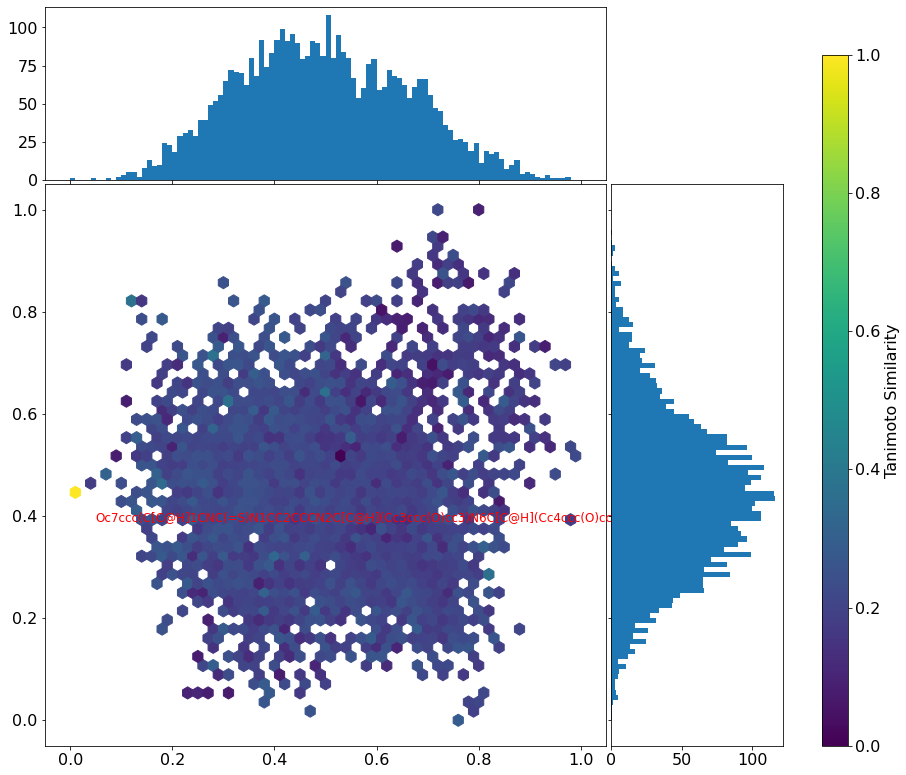

In [ ]:
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005
import matplotlib
matplotlib.rc('font', size=16)
ticks=np.arange(0,1.01,.1)

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]
print(rect_histy)
# start with a square Figure
fig = plt.figure(figsize=(12,12))
ax = fig.add_axes(rect_scatter)
cbaxes = fig.add_axes([1.00, 0.1, 0.03, 0.8])

ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

scatter_hist(plot[0], plot[1],ts, ax, ax_histx, ax_histy)
#plt.xlim(-3, 3)
#plt.ylim(-1, 10)
norm = matplotlib.colors.Normalize(vmin=0,vmax=1 )
bar = fig.colorbar(cm.ScalarMappable(norm=norm), ax=ax,cax =cbaxes,)
bar.set_label('Tanimoto Similarity')
bar.ax.set_yticklabels(['0.0','0.2','0.4','0.6','0.8','1.0'])
#plt.axis('square')


In [ ]:
fig.savefig("./FINAL_FIGURES/Tanimoto_IMPLICIT_DEEP_CHEMBL_TEST_4000", bbox_inches='tight')

In [ ]:
## Project test samples to latent space and perform 
## PCA to get the distribution of LOGP, QED, and SA Scores for ChHEMBL
from sklearn.decomposition import KernelPCA
NUM_SAMPLED = 4000
sampled_index = np.random.choice(len(test_X), NUM_SAMPLED+100 , replace=False)
sampled_points =[]
qeds = []
sass = []
logps = []
index = 0 
while len(sampled_points) != NUM_SAMPLED:
  i = sampled_index[index]
  index+=1
  smiles = test_X[i][:].reshape(1,MAX_LEN)
  eps = tf.convert_to_tensor(np.random.normal(size=(smiles.shape[0], LATENT_DIM)),dtype = tf.float32)
  if IMPLICIT:
    t = smile_vae.encoder(smiles,eps)[1]
  else:
    t = smile_vae.encoder(smiles)[1]
  if SELFIES:
    smiles = get_smiles_from_tokens(smiles[0],vocab_index)
    try:
      smiles = decoder(smiles)
    except:
      print('EXCEPT')
      continue
  elif DEEP:
    smiles = get_smiles_from_tokens(smiles[0],vocab_index)
    smiles = replace_halogens_inv(smiles)
    smiles = converter.decode(smiles)
  else:
    smiles = get_smiles_from_tokens(smiles[0],vocab_index)
    smiles = replace_halogens_inv(smiles)
  if len(sampled_points)% 100 == 0:
    print(len(sampled_points))
  sampled_points.append(t) 
  m = rdkit.Chem.MolFromSmiles(smiles)
  sass.append(sascorer.calculateScore(m))
  qeds.append(rdkit.Chem.QED.qed(m))
  logps.append(Descriptors.MolLogP(m))
 
sampled_points = np.array(sampled_points).reshape(NUM_SAMPLED,LATENT_DIM)
PCA = KernelPCA(n_components=2, kernel="linear")
data_transformed = PCA.fit_transform(sampled_points)
from sklearn.preprocessing import MinMaxScaler
scaler1 = MinMaxScaler()
scaler1.fit(np.array(data_transformed[:,0]).reshape(-1,1))
scaler2 = MinMaxScaler()
scaler2.fit(np.array(data_transformed[:,1]).reshape(-1,1))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900


MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
def scatter_hist(x, y, colors, ax, ax_histx, ax_histy):
  # no labels
  ax_histx.tick_params(axis="x", labelbottom=False)
  ax_histy.tick_params(axis="y", labelleft=False)

  # the hexbin plot:
  ax.hexbin(x,y,gridsize=50,C =colors, reduce_C_function=np.mean)


  bins = np.arange(0, 1, 0.01)
  ax_histx.hist(x, bins=bins)
  bins = np.arange(0, 1, 0.01)
  ax_histy.hist(y, bins=bins, orientation='horizontal')
  
  

In [ ]:
SASS = False
logP = True

In [ ]:
plot  = {0: [scaler1.transform(x[0].reshape(1,-1))[0][0] for x in data_transformed],
          1: [scaler2.transform(x[1].reshape(1,-1))[0][0] for x in data_transformed]}

-6.295799999999999

[0.755, 0.1, 0.2, 0.65]


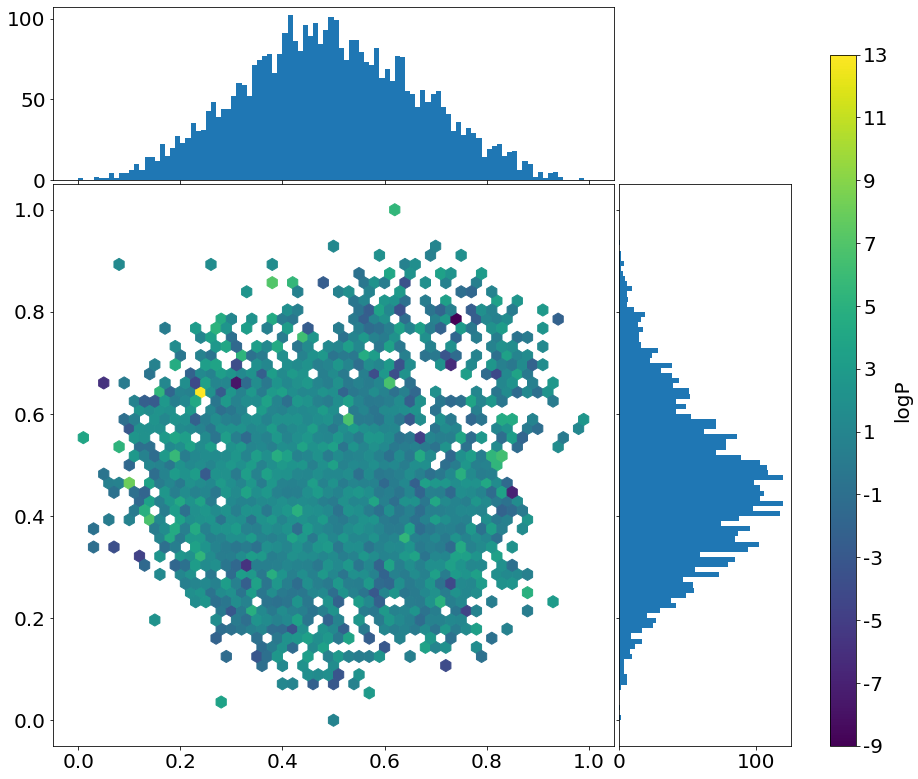

In [ ]:
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005
import matplotlib
if SASS:
  ticks=np.arange(1,10,1)
  norm = matplotlib.colors.Normalize(vmin=1,vmax=10 )
elif logP:
  ticks=np.arange(-9,13+1,2)
  norm = matplotlib.colors.Normalize(vmin=-9,vmax=13 )
else:
  ticks=np.arange(0,1.2,.2)
  norm = matplotlib.colors.Normalize(vmin=0,vmax= 1)
matplotlib.rc('font', size=20)


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]
print(rect_histy)
# start with a square Figure
fig = plt.figure(figsize=(12,12))
ax = fig.add_axes(rect_scatter)
cbaxes = fig.add_axes([1.00, 0.1, 0.03, 0.8])

ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)
if SASS:
  scatter_hist(plot[0], plot[1],sass, ax, ax_histx, ax_histy)
elif logP:
  scatter_hist(plot[0], plot[1],logps, ax, ax_histx, ax_histy)
else:
  scatter_hist(plot[0], plot[1],qeds, ax, ax_histx, ax_histy)
#plt.xlim(-3, 3)
#plt.ylim(-1, 10)
bar =fig.colorbar(cm.ScalarMappable(norm=norm), ax=ax,cax =cbaxes,ticks=ticks)
#bar.ax.set_yticks()

bar.ax.set_yticklabels(ticks)
if SASS:
  bar.set_label('SA Scores')
elif logP:
  bar.set_label('logP')
else:
  bar.set_label('QED')
  bar.ax.set_yticklabels(['0.0','0.2','0.4','0.6','0.8','1.0'])


#plt.axis('square')
plt.show()



In [ ]:
fig.savefig("./FINAL_FIGURES/LOGP_DEEP_CHEMBL_TEST_4000", bbox_inches='tight')

In [ ]:
## Project test samples to latent space and perform 
## PCA to get the distribution of LOGP, QED, and SA Scores for ZINC
from sklearn.decomposition import KernelPCA
NUM_SAMPLED = 4000
sampled_index = np.random.choice(len(zinc_test_X), NUM_SAMPLED+100 , replace=False)
sampled_points =[]
qeds = []
sass = []
logps = []
index = 0 
while len(sampled_points) != NUM_SAMPLED:
  i = sampled_index[index]
  index+=1
  smiles = zinc_test_X[i][:].reshape(1,MAX_LEN)
  eps = tf.convert_to_tensor(np.random.normal(size=(smiles.shape[0], LATENT_DIM)),dtype = tf.float32)
  if IMPLICIT:
    t = smile_vae.encoder(smiles,eps)[1]
  else:
    t = smile_vae.encoder(smiles)[1]
  if SELFIES:
    smiles = get_smiles_from_tokens(smiles[0],vocab_index)
    try:
      smiles = decoder(smiles)
    except:
      continue
  elif DEEP:
    smiles = get_smiles_from_tokens(smiles[0],vocab_index)
    smiles = replace_halogens_inv(smiles)
    smiles = converter.decode(smiles)
  else:
    smiles = get_smiles_from_tokens(smiles[0],vocab_index)
    smiles = replace_halogens_inv(smiles)
  if len(sampled_points)% 100 == 0:
    print(len(sampled_points))
  sampled_points.append(t) 
  m = rdkit.Chem.MolFromSmiles(smiles)
  sass.append(sascorer.calculateScore(m))
  qeds.append(rdkit.Chem.QED.qed(m))
  logps.append(Descriptors.MolLogP(m))
sampled_points = np.array(sampled_points).reshape(NUM_SAMPLED,LATENT_DIM)
PCA = KernelPCA(n_components=2, kernel="linear")
data_transformed = PCA.fit_transform(sampled_points)
from sklearn.preprocessing import MinMaxScaler
scaler1 = MinMaxScaler()
scaler1.fit(np.array(data_transformed[:,0]).reshape(-1,1))
scaler2 = MinMaxScaler()
scaler2.fit(np.array(data_transformed[:,1]).reshape(-1,1))

In [ ]:
plot  = {0: [scaler1.transform(x[0].reshape(1,-1))[0][0] for x in data_transformed],
             1: [scaler2.transform(x[1].reshape(1,-1))[0][0] for x in data_transformed]}

In [ ]:
def scatter_hist(x, y, colors, ax, ax_histx, ax_histy):
  # no labels
  ax_histx.tick_params(axis="x", labelbottom=False)
  ax_histy.tick_params(axis="y", labelleft=False)

  # the hexbin plot:
  ax.hexbin(x,y,gridsize=50,C =colors, reduce_C_function=np.mean)

  # now determine nice limits by hand:
  #binwidth = 0.000025
  #xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
  #lim = (int(xymax/binwidth) + 1) * binwidth


  bins = np.arange(0, 1, 0.01)
  ax_histx.hist(x, bins=bins)
  bins = np.arange(0, 1, 0.01)
  ax_histy.hist(y, bins=bins, orientation='horizontal')
  
  

In [ ]:
SASS = False
logP = True

In [ ]:
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005
import matplotlib
if SASS:
  ticks=np.arange(1,10,1)
  norm = matplotlib.colors.Normalize(vmin=1,vmax=10 )
elif logP:
  ticks=np.arange(-9,13+1,2)
  norm = matplotlib.colors.Normalize(vmin=-9,vmax=13 )
else:
  ticks=np.arange(0,1.2,.2)
  norm = matplotlib.colors.Normalize(vmin=0,vmax= 1)
matplotlib.rc('font', size=16)


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]
print(rect_histy)
# start with a square Figure
fig = plt.figure(figsize=(12,12))
ax = fig.add_axes(rect_scatter)
cbaxes = fig.add_axes([1.00, 0.1, 0.03, 0.8])

ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)
if SASS:
  scatter_hist(plot[0], plot[1],sass, ax, ax_histx, ax_histy)
elif logP:
  scatter_hist(plot[0], plot[1],logps, ax, ax_histx, ax_histy)
else:
  scatter_hist(plot[0], plot[1],qeds, ax, ax_histx, ax_histy)
#plt.xlim(-3, 3)
#plt.ylim(-1, 10)
bar =fig.colorbar(cm.ScalarMappable(norm=norm), ax=ax,cax =cbaxes,ticks=ticks)#bar.ax.set_yticks()

bar.ax.set_yticklabels(ticks)
if SASS:
  bar.set_label('SA Scores')
elif logP:
  bar.set_label('logP')
else:
  bar.set_label('QED')
  bar.ax.set_yticklabels(['0.0','0.2','0.4','0.6','0.8','1.0'])


#plt.axis('square')
plt.show()



In [ ]:
fig.savefig("./FINAL_FIGURES/LOGP_IMPLICIT_SMILES_ZINC_4000", bbox_inches='tight')

In [ ]:
## Start Optimzation 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from numpy.random import multivariate_normal
import GPyOpt
from GPyOpt.methods import BayesianOptimization

sampled_smiles = np.array(sampled_smiles)
sampled_smiles= sampled_smiles.reshape(len(sampled_smiles),LATENT_DIM)

In [ ]:
import GANS.ic50predictions as ic50predictions
from IPython.display import SVG, display
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import PandasTools

In [ ]:
## Load in necessary file for prediction
ic50pred = ic50predictions.IC50_MCA(vocab_size=VOCAB_SIZE, 
                    embedding_dim =EMBEDDING_DIM, num_genes =2128,
                    hidden_dim = HIDDEN_DIM, max_len = MAX_LEN, 
                    latent_dim = LATENT_DIM)
if SELFIES:
  ic50pred.load_weights('new_ic50network_selfies') 
else:
  ic50pred.load_weights('new_updated_ic50g_ic50network_smiles_basic')

In [ ]:
## Create domain bounds ##
bounds  =[(-4,4)]*LATENT_DIM 
domains = []
for idx in range(len(bounds)):
  domain =  {'name': 'latent'+str(idx), 'type': 'continuous'}
  domain['domain'] = bounds[idx]     
  domains.append(domain)      

In [ ]:
def obj_function(z):
  x = 0
  val = ic50pred(encoded_smiles = z, genes = sampled_gene_expressions[0].reshape(1,2128)).numpy()[0][0] - x
  print(val)
  return val

In [ ]:
UBO = BayesianOptimization(f=obj_function, X =sampled_smiles,Y = sampled_predictions,
                           domain=domains,batch_size=1,initial_design_numdata=0)


In [ ]:
MAX_ITER = 500
UBO.run_optimization(max_iter = MAX_ITER)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

0.4718022048473358
0.5642216205596924
0.4405190050601959
KeyboardInterrupt caught, calling on_optimization_end() to round things up


KeyboardInterrupt: ignored

In [ ]:
UBO.plot_convergence()

In [ ]:
ins = np.array(UBO.X).tolist()
print(len(ins))
outs = np.array(UBO.Y ).tolist()
print(len(outs))
outs, ins = (list(t) for t in zip(*sorted(zip(outs, ins))))

In [ ]:
print("Value of z that minimises the objective:" + str(UBO.x_opt)) 
print("Maximum value of the objective: "+str(UBO.fx_opt))     


In [ ]:
def smiles_check(smiles):
  try:
    mol = rdkit.Chem.MolFromSmiles(smiles)
    if mol is not None:
      return smiles
  except:
    pass
  return None

In [ ]:
def smiles_to_mol(smiles):
  try:
    mol = rdkit.Chem.MolFromSmiles(smiles)
    return mol
  except:
    return None

In [ ]:
## Perform conversion of latent space back to original SMILES
def smile_to_smiles_percentage(z,norm,decode_attempts=256):
  z_mean = z 
  zs = []
  #decode_attempts = 256
  for i in range(decode_attempts):
    zn  = perturb_z(z_mean,norm)
    zs.append(zn)
  zs = np.array(zs)
  zs = zs.reshape((zs.shape[0],zs.shape[-1]))
  x_decoded = []
  if TRANSFORMER_DECODE:
    x_decoded = transformer(zs)
  else:
    x_decoded = smile_vae.decoder(zs)
  decoded_smiles = []
  for x_dec in x_decoded:
    decoded_smiles.append(get_smiles_from_logits(tf.reshape(x_dec,[1,MAX_LEN,VOCAB_SIZE]),vocab_index))
  actual_smiles =decoded_smiles
  if DEEP == True:
    actual_smiles = get_smiles_from_deep(decoded_smiles)
    correct_smiles =[replace_halogens_inv(v) for i,v in enumerate(actual_smiles) if v != None and v != '' ]
  elif SELFIES:
    actual_smiles = get_smiles_from_selfies(decoded_smiles)
    correct_smiles =[v for i,v in enumerate(actual_smiles) if v != None]
  else:
    correct_smiles =[replace_halogens_inv(v) for i,v in enumerate(actual_smiles) if v != None and v != '' ]
  actual_correct_smiles = []
  for smiles in correct_smiles:
    actual_correct_smiles.append(smiles_check(smiles))
  actual_correct_smiles =[v for i,v in enumerate(actual_correct_smiles) if v != None ]
  num_samples = len(actual_correct_smiles)
  generator = MockGenerator(actual_correct_smiles)
  benchmark = UniquenessBenchmark(number_samples=num_samples)
  #print(benchmark.assess_model(generator).score*decode_attempts)
  return actual_correct_smiles

In [ ]:
def encode(smiles_list):
  means = []
  for smiles  in smiles_list:
    tok_smile = None
    if SELFIES:
      tok_smile =tokenize_selfies(smiles)
    else:
      tok_smile = replace_halogens(smiles)
      tok_smile = tokenize_smiles(tok_smile)
    if SELFIES:
      smile_ordered = integer_encode_selfies(tok_smile,vocab)
    else:
      smile_ordered = integer_encode(tok_smile,vocab) 
    t = tf.keras.preprocessing.sequence.pad_sequences(np.array(smile_ordered).reshape(1,len(smile_ordered)),maxlen = PAD_SIZE,padding='post')
    h, z_mean,z_log_var  = smile_vae.encoder(np.array(t))
    means.append(z_mean)
  return means

In [ ]:
import pandas as pd

def smiles_distance_z(smiles_list, z0):
  dists = []
  z_reps = encode(smiles_list)
  for z_rep in z_reps:
    dists.append(np.linalg.norm(z0 - z_rep, axis=None))
  return np.array(dists)

def ic50_dfcalc(smiles_list):
  vals = []
  z_reps = encode(smiles_list)
  for z_rep in z_reps:
    if z_rep == None:
      vals.append(None)
    else:
      val = ic50pred(encoded_smiles = z_rep, genes = sampled_gene_expressions[0].reshape(1,2128)).numpy()[0][0]
      val = ic50_scaler.inverse_transform(np.array(val).reshape(-1,1))
      vals.append(val[0])
  return np.array(vals)

def sas_dfcalc(smiles_list):
  vals = []
  for smiles in smiles_list:  
    try:
      m = rdkit.Chem.MolFromSmiles(smiles)
      if m is not None:
        vals.append(sascorer.calculateScore(m))
      else:
        vals.append(None)
    except:
      vals.append(None)
  return np.array(vals)

def qed_dfcalc(smiles_list):
  vals = []
  for smiles in smiles_list:
    try:
      m = rdkit.Chem.MolFromSmiles(smiles)
      if m is not None:
        vals.append(rdkit.Chem.QED.qed(m))
      else:
        vals.append(None)
    except:
      vals.append(None)
  return np.array(vals)

def logp_dfcalc(smiles_list):
  vals = []
  for smiles in smiles_list:
    try:
      m = rdkit.Chem.MolFromSmiles(smiles)
      if m is not None:
        vals.append(Descriptors.MolLogP(m))
      else:
        vals.append(None)
    except:
      vals.append(None)
  return np.array(vals)


## Method to display newly dicovered SMILES
def prep_mol_df_i( smiles):
  df = pd.DataFrame({'smiles': smiles})
  sort_df = pd.DataFrame(df[['smiles']].groupby(
      by='smiles').size().rename('count').reset_index())
      
  df = df.merge(sort_df, on='smiles')
  df = df.drop_duplicates(subset='smiles')
  df = df[df['smiles'] != '']
  df.reset_index(drop=True, inplace=True)
  #df = df[df['smiles'].apply(fast_verify)]
  if len(df) > 0:
      df['mol'] = df['smiles'].apply(smiles_to_mol)
  if len(df) > 0:
      df = df[pd.notnull(df['mol'])]
  t = df['smiles']
  if len(df) > 0:
      #df['distance'] = smiles_distance_z(t, z)
      df['frequency'] = df['count'] / float(sum(df['count']))
      df['IC50'] = ic50_dfcalc(t)
      df['QED'] = qed_dfcalc(t)
      df['LOGP'] = logp_dfcalc(t)
      df['SAS'] = sas_dfcalc(t)
      df = df[['smiles', 'count', 'frequency','IC50','QED','LOGP','SAS','mol']]
      df.sort_values(by='IC50', inplace=True)
      df.reset_index(drop=True, inplace=True)
  return df

def prep_mol_df( smiles, z):
  df = pd.DataFrame({'smiles': smiles})
  sort_df = pd.DataFrame(df[['smiles']].groupby(
      by='smiles').size().rename('count').reset_index())
      
  df = df.merge(sort_df, on='smiles')
  df = df.drop_duplicates(subset='smiles')
  df = df[df['smiles'] != '']
  df.reset_index(drop=True, inplace=True)
  #df = df[df['smiles'].apply(fast_verify)]
  if len(df) > 0:
      df['mol'] = df['smiles'].apply(smiles_to_mol)
  if len(df) > 0:
      df = df[pd.notnull(df['mol'])]
  t = df['smiles']
  if len(df) > 0:
      df['distance'] = smiles_distance_z(t, z)
      df['frequency'] = df['count'] / float(sum(df['count']))
      df['IC50'] = ic50_dfcalc(t)
      df['QED'] = qed_dfcalc(t)
      df['LOGP'] = logp_dfcalc(t)
      df['SAS'] = sas_dfcalc(t)
      df = df[['smiles', 'distance', 'count', 'frequency','IC50','QED','LOGP','SAS','mol']]
      df.sort_values(by='IC50', inplace=True)
      df.reset_index(drop=True, inplace=True)
  return df 

In [ ]:
## Perform genetic algorithm for optimization:
## We keep the top 500 examples:
def get_trad_score(compound):
  m = rdkit.Chem.MolFromSmiles(compound)
  sas  = sascorer.calculateScore(m)
  qed = rdkit.Chem.QED.qed(m)
  return 5*qed -sas 

In [ ]:
def get_trad_scores(compounds):
  scores = []
  for compound in compounds:
    scores.append(get_trad_score(compound))
  return np.array(scores)

In [ ]:
## Perform genetic algorithm for optimization:
## We keep the top 500 examples:
def get_ic50s(latents, gene_expression):
  num_gene_expressions = []
  for i in range(len(latents)):
    num_gene_expressions.append(gene_expression)
  num_gene_expressions = np.array(num_gene_expressions)
  while True:
    try:
      ic50s_preds = ic50pred(encoded_smiles=np.array(latents),genes =num_gene_expressions.reshape(len(latents),2128))
    except:
      print('IC50 PREDICTION EXCEPTION')
      continue
    break
  return ic50s_preds

def get_ic50s_mult(latents, gene_expressions):
  avg_ic50s = []
  for j in range(len(latents)):
    g_avg_ic50s = []    
    num_latents = []
    for i in range(len(gene_expressions)):
      num_latents.append(latents[j])
    num_latents = np.array(num_latents)
    while True:
      try:
        g_avg_ic50s.append(ic50pred(encoded_smiles=np.array(num_latents),genes =gene_expressions.reshape(len(gene_expressions),2128)))
      except:
        print('IC50 PREDICTION EXCEPTION')
        continue
      break
    avg_ic50s.append(np.average(g_avg_ic50s))
  return avg_ic50s

In [ ]:
## Genetic algorithm for optimizing ic50
current_smiles = list(np.array(sampled_smiles).reshape(-1,LATENT_DIM))
decoded_smiles = list(np.array(real_sampled_smiles))
gene_expression = np.array(sampled_gene_expressions[66])
top_ic50s = list(get_ic50s(current_smiles, gene_expression))
norm = 10.0
num_generations = 10
num_out = 100
num_children = 10
for generation in range(num_generations):
  new_current_smiles =[]
  new_decoded_smiles = []
  new_ic50s = []
  idx = 0 
  if len(current_smiles) != 0:
    for i in range(num_children):
      parent1 = np.random.randint(0,len(current_smiles))
      parent2 = np.random.randint(0,len(current_smiles))
      diff  = np.random.uniform(0, 1.0)
      child1 = np.array(current_smiles[parent1])*diff + (1-diff)*np.array(current_smiles[parent2])
      child2 = np.array(current_smiles[parent1])*(1-diff)+ diff*np.array(current_smiles[parent2])

      ## Add child1
      new_smiles = smile_to_smiles_percentage(np.array(child1).reshape(-1,LATENT_DIM),1.0)
      new_smiles = set(new_smiles)
      cnew_decoded_smiles = []
      cnew_decoded_smiles.extend(new_smiles)
      new_smiles_enc = np.array(encode(new_smiles)).reshape(-1,LATENT_DIM)
      if new_smiles_enc.shape[0] != 0:
        print('New Child')
        ic50_preds = list(get_ic50s(new_smiles_enc,gene_expression))
        new_ic50s.extend(ic50_preds)
        new_current_smiles.extend(list(new_smiles_enc))
        new_decoded_smiles.extend(cnew_decoded_smiles)


      ## Add child2
      new_smiles = smile_to_smiles_percentage(np.array(child2).reshape(-1,LATENT_DIM),1.0)
      new_smiles = set(new_smiles)
      cnew_decoded_smiles = []
      cnew_decoded_smiles.extend(new_smiles)
      new_smiles_enc = np.array(encode(new_smiles)).reshape(-1,LATENT_DIM)
      if new_smiles_enc.shape[0] != 0:
        print('New Child')
        ic50_preds = list(get_ic50s(new_smiles_enc,gene_expression))
        new_ic50s.extend(ic50_preds)
        new_current_smiles.extend(list(new_smiles_enc))
        new_decoded_smiles.extend(cnew_decoded_smiles)
    if len(new_ic50s) != 0:
      print("BEST CHILD: " +new_decoded_smiles[np.argmin(new_ic50s)])
      print("BEST CHILD IC50: {:.5f}".format(min(new_ic50s)[0])+'\n')
  for smiles in current_smiles:
    #norm = np.random.uniform(0, jump_size)
    new_smiles = smile_to_smiles_percentage(np.array(smiles).reshape(-1,LATENT_DIM),norm)
    new_smiles = set(new_smiles)
    cnew_decoded_smiles = list([decoded_smiles[idx]])
    cnew_decoded_smiles.extend(new_smiles)
    new_smiles_enc = np.array(encode(new_smiles)).reshape(-1,LATENT_DIM)
    new_smiles_enc = np.concatenate((np.array(smiles).reshape(-1,LATENT_DIM),new_smiles_enc))
    ic50_preds = list(get_ic50s(new_smiles_enc,gene_expression))
    new_ic50s.extend(ic50_preds)
    new_current_smiles.extend(list(new_smiles_enc))
    new_decoded_smiles.extend(cnew_decoded_smiles)
    print("BEST CURRENT EVOLUTION: "+new_decoded_smiles[np.argmin(new_ic50s)])
    print("BEST EVOLUTION IC50 : {:.5f}".format(min(new_ic50s)[0])+'\n')
    idx +=1
  print('THIS GENERATION:')
  decoded_smiles.extend(new_decoded_smiles)
  current_smiles.extend(new_current_smiles)
  top_ic50s.extend(new_ic50s)
  top_ic50s, current_smiles,decoded_smiles = (list(t) for t in zip(*sorted(zip(top_ic50s, np.array(current_smiles).tolist(), np.array(decoded_smiles).tolist()  ))))
  non_repeat_decoded_smiles = []
  indexes = []
  index = 0 
  for smiles in decoded_smiles:
    if smiles not in non_repeat_decoded_smiles:
      non_repeat_decoded_smiles.append(smiles)
      indexes.append(index)
    index+=1
  decoded_smiles =np.array(decoded_smiles)[indexes].tolist()
  top_ic50s =np.array(top_ic50s)[indexes].tolist()
  current_smiles =np.array(current_smiles)[indexes].tolist()
  top_ic50s = top_ic50s[:num_out]
  current_smiles = current_smiles[:num_out]
  decoded_smiles = decoded_smiles[:num_out]
  print("BEST GENERATION : "+ decoded_smiles[np.argmin(top_ic50s)])
  print("BEST GENERATION IC50 : {:.5f}".format(min(top_ic50s)[0]) +'\n')
  print(decoded_smiles)

In [ ]:
## Genetic algorithm for optimizing SAS/QED

#current_smiles = list(np.array(sampled_smiles).reshape(-1,LATENT_DIM))
current_smiles = current_smiles
decoded_smiles = decoded_smiles
#decoded_smiles = list(np.array(real_sampled_smiles))
top_trads = list(get_trad_scores(decoded_smiles))
norm = 10.0
num_generations = 1
num_out = 100
num_children = 10
for generation in range(num_generations):
  new_current_smiles =[]
  new_decoded_smiles = []
  new_trads = []
  idx = 0 
  if len(current_smiles) != 0:
    for i in range(num_children):
      parent1 = np.random.randint(0,len(current_smiles))
      parent2 = np.random.randint(0,len(current_smiles))
      diff  = np.random.uniform(0, 1.0)
      child1 = np.array(current_smiles[parent1])*diff + (1-diff)*np.array(current_smiles[parent2])
      child2 = np.array(current_smiles[parent1])*(1-diff)+ diff*np.array(current_smiles[parent2])

      try:
        ## Add child1
        new_smiles = smile_to_smiles_percentage(np.array(child1).reshape(-1,LATENT_DIM),1.0)
        new_smiles = set(new_smiles)
        cnew_decoded_smiles = []
        cnew_decoded_smiles.extend(new_smiles)
        new_smiles_enc = np.array(encode(new_smiles)).reshape(-1,LATENT_DIM)
        if new_smiles_enc.shape[0] != 0:
          print('New Child')
          trad_scores = list(get_trad_scores(cnew_decoded_smiles))
          new_trads.extend(trad_scores)
          new_current_smiles.extend(list(new_smiles_enc))
          new_decoded_smiles.extend(cnew_decoded_smiles)
      except:
        continue


      ## Add child2
      try:
        new_smiles = smile_to_smiles_percentage(np.array(child2).reshape(-1,LATENT_DIM),1.0)
        new_smiles = set(new_smiles)
        cnew_decoded_smiles = []
        cnew_decoded_smiles.extend(new_smiles)
        new_smiles_enc = np.array(encode(new_smiles)).reshape(-1,LATENT_DIM)
        if new_smiles_enc.shape[0] != 0:
          print('New Child')
          trad_scores = list(get_trad_scores(cnew_decoded_smiles))
          new_trads.extend(trad_scores)
          new_current_smiles.extend(list(new_smiles_enc))
          new_decoded_smiles.extend(cnew_decoded_smiles)
      except:
        continue
    if len(new_trads) != 0:
      print("BEST CHILD: " +new_decoded_smiles[np.argmax(new_trads)])
      print("BEST CHILD TRAD: {:.5f}".format(max(new_trads))+'\n')
  for smiles in current_smiles:
    #norm = np.random.uniform(0, jump_size)
    new_smiles = smile_to_smiles_percentage(np.array(smiles).reshape(-1,LATENT_DIM),norm)
    new_smiles = set(new_smiles)
    cnew_decoded_smiles = list([decoded_smiles[idx]])
    cnew_decoded_smiles.extend(new_smiles)
    new_smiles_enc = np.array(encode(new_smiles)).reshape(-1,LATENT_DIM)
    new_smiles_enc = np.concatenate((np.array(smiles).reshape(-1,LATENT_DIM),new_smiles_enc))
    trad_scores = list(get_trad_scores(cnew_decoded_smiles))
    new_trads.extend(trad_scores)
    new_current_smiles.extend(list(new_smiles_enc))
    new_decoded_smiles.extend(cnew_decoded_smiles)
    print("BEST CURRENT EVOLUTION: "+new_decoded_smiles[np.argmax(new_trads)])
    print("BEST EVOLUTION TRAD : {:.5f}".format(max(new_trads))+'\n')
    idx +=1
  print('THIS GENERATION:')
  decoded_smiles.extend(new_decoded_smiles)
  current_smiles.extend(new_current_smiles)
  top_trads.extend(new_trads)
  top_trads, current_smiles,decoded_smiles = (list(t) for t in zip(*sorted(zip(top_trads, np.array(current_smiles).tolist(), np.array(decoded_smiles).tolist()  ), reverse=True)))
  non_repeat_decoded_smiles = []
  indexes = []
  index = 0 
  for smiles in decoded_smiles:
    if smiles not in non_repeat_decoded_smiles:
      indexes.append(index)
    index+=1
  decoded_smiles =np.array(decoded_smiles)[indexes].tolist()
  top_trads =np.array(top_trads)[indexes].tolist()
  current_smiles =np.array(current_smiles)[indexes].tolist()
  top_trads = top_trads[:num_out]
  current_smiles = current_smiles[:num_out]
  decoded_smiles = decoded_smiles[:num_out]
  print("BEST GENERATION : "+ decoded_smiles[np.argmax(top_trads)])
  print("BEST GENERATION TRAD : {:.5f}".format(max(top_trads)) +'\n')
  print(decoded_smiles)

New Child
New Child
New Child
New Child
New Child
New Child
New Child
New Child
New Child
New Child
New Child
New Child
New Child
New Child
New Child
New Child
New Child
New Child
New Child
New Child
BEST CHILD: CCNC(=O)C1=C(C(=C2C=C(C(=CC2=C(C)C)C)C)ON1)C3=CC=C(C=C3)N4CCCCC4
BEST CHILD TRAD: 0.72055

BEST CURRENT EVOLUTION: CCNC(=O)C1=C(C(=C2C=C(C(=CC2=C(C)C)C)C)ON1)C3=CC=C(C=C3)N4CCCCC4
BEST EVOLUTION TRAD : 0.72055

BEST CURRENT EVOLUTION: CCNC(=O)C1=C(C(=C2C=C(C(=CC2=C(C)C)C)C)ON1)C3=CC=C(C=C3)N4CCCCC4
BEST EVOLUTION TRAD : 0.72055

BEST CURRENT EVOLUTION: CCNC(=O)C1=C(C(=C2C=C(C(=CC2=C(C)C)C)C)ON1)C3=CC=C(C=C3)N4CCCCC4
BEST EVOLUTION TRAD : 0.72055

BEST CURRENT EVOLUTION: CCNC(=O)C1=C(C(=C2C=C(C(=CC2=C(C)C)C)C)ON1)C3=CC=C(C=C3)N4CCCCC4
BEST EVOLUTION TRAD : 0.72055

BEST CURRENT EVOLUTION: CCNC(=O)C1=C(C(=C2C=C(C(=CC2=C(C)C)C)C)ON1)C3=CC=C(C=C3)N4CCCCC4
BEST EVOLUTION TRAD : 0.72055

BEST CURRENT EVOLUTION: CCNC(=O)C1=C(C(=C2C=C(C(=CC2=C(C)C)C)C)ON1)C3=CC=C(C=C3)N4CCCCC4
BEST EVO

In [ ]:
top_trads = top_trads[:num_out]
current_smiles = current_smiles[:num_out]
decoded_smiles = decoded_smiles[:num_out]
print("BEST GENERATION : "+ decoded_smiles[np.argmax(top_trads)])
print("BEST GENERATION TRAD : {:.5f}".format(max(top_trads)) +'\n')
print(decoded_smiles)

BEST GENERATION : CCNC(=O)C1=C(C(=C2C=C(C(=CC2=O)F)C(C)C)ON1)C3=CC=C(C=C3)CN4CCCO4
BEST GENERATION TRAD : -0.19246

['CCNC(=O)C1=C(C(=C2C=C(C(=CC2=O)F)C(C)C)ON1)C3=CC=C(C=C3)CN4CCCO4', 'CCNC(=O)C1=C(C(=C2C=C(C(=CC2=O)N)C(C)C)ON1)C3=CC=C(C=C3)CN4CCCO4', 'CCNC(=O)C1=C(C(=C2C=C(C(=CC2=O)N)C(C)C)ON1)C3=CC=C(C=C3)CN4CCCO4', 'CCNC(=O)C1=C(C(=C2C=C(C(=NC2=C(Cl)Cl)C)O)ON1)C3=CC=C(C=C3)N4CCC=C4', 'CCNC(=O)C1=C(C(=C2C=C(C(=CC2=C(Cl)Cl)Cl)O)ON1)C3=CC=C(C=C3)CN4CCOC4', 'CCNC(=O)C1=C(C(=C2C=C(C(=CC2=O)N(C)C)OC)S1)C3=CC=C(C=C3)OC4CCOC4', 'CCNC(=O)C1=C(C(=C2C=C(C(=CC2=O)N(C)C)OC)S1)C3=CC=C(C=C3)OC4CCOC4', 'CCNC(=O)C1=C(C(=C2C=C(C(=CC2=O)N(C)C)OC)S1)C3=CC=C(C=C3)OC4CCOC4', 'CCNC(=O)C1=C(C(=C2C=C(C(=CC2=O)N(C)C)O)O1)SC3=CC=C(C=C3)CC4CCOC4', 'CCNC(=O)C1=C(C(=C2C=C(C(=CC2=O)N(C)C)O)O1)SC3=CC=C(C=C3)OC4CCOC4', 'CCNC(=O)C1=C(C(=C2C=C(C(=CC2=C(Cl)Cl)Cl)O)NN1)C3=CC=C(C=C3)CN4CCOC4', 'CCNC(=O)C1=C(C(=C2C=C(C(=CC2=C(Cl)Cl)Cl)O)NN1)C3=CC=C(C=C3)CN4CCOC4', 'CCNC(=O)C1=C(C(=C2C=C(C(=CC2=C(Cl)Cl)Cl)O)NN1)C3=CC=C(C

In [ ]:
## MULT 
## Genetic algorithm for optimizing Sarcoma drugs 

current_smiles = list(np.array(sarcoma_smiles_z).reshape(-1,LATENT_DIM))
decoded_smiles = list(sarcoma_smiles)
gene_expression = np.array(sarcoma_gene_expressions)
top_ic50s = list(get_ic50s_mult(current_smiles, gene_expression))
norm = 10.0
num_generations = 10
num_out = 100
num_children = 10
for generation in range(num_generations):
  new_current_smiles =[]
  new_decoded_smiles = []
  new_ic50s = []
  idx = 0 
  if len(current_smiles) != 0:
    for i in range(num_children):
      parent1 = np.random.randint(0,len(current_smiles))
      parent2 = np.random.randint(0,len(current_smiles))
      diff  = np.random.uniform(0, 1.0)
      child1 = np.array(current_smiles[parent1])*diff + (1-diff)*np.array(current_smiles[parent2])
      child2 = np.array(current_smiles[parent1])*(1-diff)+ diff*np.array(current_smiles[parent2])

      ## Add child1
      new_smiles = smile_to_smiles_percentage(np.array(child1).reshape(-1,LATENT_DIM),1.0)
      try:
        new_smiles = set(new_smiles)
        cnew_decoded_smiles = []
        cnew_decoded_smiles.extend(new_smiles)
        new_smiles_enc = np.array(encode(new_smiles)).reshape(-1,LATENT_DIM)
        if len(new_smiles_enc) != 0:
          ic50_preds = list(get_ic50s_mult(new_smiles_enc,gene_expression))
          new_ic50s.extend(ic50_preds)
          new_current_smiles.extend(list(new_smiles_enc))
          new_decoded_smiles.extend(cnew_decoded_smiles)
      except:
        continue


      ## Add child2
      new_smiles = smile_to_smiles_percentage(np.array(child2).reshape(-1,LATENT_DIM),1.0)
      try:
        new_smiles = set(new_smiles)
        cnew_decoded_smiles = []
        cnew_decoded_smiles.extend(new_smiles)
        new_smiles_enc = np.array(encode(new_smiles)).reshape(-1,LATENT_DIM)
        if len(new_smiles_enc) != 0:
          ic50_preds = list(get_ic50s_mult(new_smiles_enc,gene_expression))
          new_ic50s.extend(ic50_preds)
          new_current_smiles.extend(list(new_smiles_enc))
          new_decoded_smiles.extend(cnew_decoded_smiles)
      except:
        continue
    print("BEST CHILD: " +new_decoded_smiles[np.argmin(new_ic50s)])
    print("BEST CHILD IC50: {:.5f}".format(min(new_ic50s))+'\n')

  for smiles in current_smiles:
    #norm = np.random.uniform(0, jump_size)
    new_smiles = smile_to_smiles_percentage(np.array(smiles).reshape(-1,LATENT_DIM),norm)
    try:
      new_smiles = set(new_smiles)
      cnew_decoded_smiles = list([decoded_smiles[idx]])
      cnew_decoded_smiles.extend(new_smiles)
      new_smiles_enc = np.array(encode(new_smiles)).reshape(-1,LATENT_DIM)
      new_smiles_enc = np.concatenate((np.array(smiles).reshape(-1,LATENT_DIM),new_smiles_enc))
      ic50_preds = list(get_ic50s_mult(new_smiles_enc,gene_expression))
      new_ic50s.extend(ic50_preds)
      new_current_smiles.extend(list(new_smiles_enc))
      new_decoded_smiles.extend(cnew_decoded_smiles)
    except:
      continue
    print("BEST CURRENT EVOLUTION: "+new_decoded_smiles[np.argmin(new_ic50s)])
    print("BEST EVOLUTION IC50 : {:.5f}".format(min(new_ic50s))+'\n')
    idx +=1
  print('THIS GENERATION:')
  decoded_smiles.extend(new_decoded_smiles)
  current_smiles.extend(new_current_smiles)
  top_ic50s.extend(new_ic50s)
  top_ic50s, current_smiles,decoded_smiles = (list(t) for t in zip(*sorted(zip(top_ic50s, np.array(current_smiles).tolist(), np.array(decoded_smiles).tolist()  ))))
  non_repeat_decoded_smiles = []
  indexes = []
  index = 0 
  for smiles in decoded_smiles:
    if smiles not in non_repeat_decoded_smiles:
      non_repeat_decoded_smiles.append(smiles)
      indexes.append(index)
    index+=1
  decoded_smiles =np.array(decoded_smiles)[indexes].tolist()
  top_ic50s =np.array(top_ic50s)[indexes].tolist()
  current_smiles =np.array(current_smiles)[indexes].tolist()
  top_ic50s = top_ic50s[:num_out]
  current_smiles = current_smiles[:num_out]
  decoded_smiles = decoded_smiles[:num_out]
  print("BEST GENERATION : "+ decoded_smiles[np.argmin(top_ic50s)])
  print("BEST GENERATION IC50 : {:.5f}".format(min(top_ic50s)) +'\n')
  print(decoded_smiles)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

BEST CHILD: CN(C(=S)C1=CC=CC=C1)NC(=O)CC(=O)ON(C)C(=S)C2=CC=CC=C2
BEST CHILD IC50: 0.22811

BEST CURRENT EVOLUTION: CN(C(=S)C1=CC=CC=C1)NC(=O)CC(=O)ON(C)C(=S)C2=CC=CC=C2
BEST EVOLUTION IC50 : 0.22811

BEST CURRENT EVOLUTION: CN(C(=S)C1=CC=CC=C1)NC(=O)CC(=O)ON(C)C(=S)C2=CC=CC=C2
BEST EVOLUTION IC50 : 0.22811

BEST CURRENT EVOLUTION: CN(C(=S)C1=CC=CC=C1)NC(=O)CC(=O)ON(C)C(=S)C2=CC=CC=C2
BEST EVOLUTION IC50 : 0.22811

BEST CURRENT EVOLUTION: CN(C(=S)C1=CC=CC=C1)NC(=O)CC(=O)ON(C)C(=S)C2=CC=CC=C2
BEST EVOLUT

In [ ]:
## Get neessary train approved cancer drugs for comparsion
train_smiles_path = './Datasets/train_Tox_data.smi'
smiles_train =  pd.read_csv(train_smiles_path,delimiter='\t',header=None)

In [ ]:
ms = [rdkit.Chem.MolFromSmiles(x) for x in smiles_train[0]]
indexs = [i for i,v in enumerate(ms) if v != None]
ms =[v for i,v in enumerate(ms) if v != None]
fps_drugs = [rdkit.Chem.RDKFingerprint(x) for x in ms]

In [ ]:
ms = [rdkit.Chem.MolFromSmiles(x) for x in decoded_smiles]
indexs = [i for i,v in enumerate(ms) if v != None]
ms =[v for i,v in enumerate(ms) if v != None]
fps_cand = [rdkit.Chem.RDKFingerprint(x) for x in ms]

In [ ]:
from rdkit import DataStructs
closest_drugs = []
closest_values = []
for idx1 in range(len(fps_cand)):
  closest_drugs.append(smiles_train[0][0])
  closest_values.append(0)
  for idx2 in range(len(fps_drugs)):
    tanimoto = DataStructs.FingerprintSimilarity(fps_cand[idx1],fps_drugs[idx2])
    if closest_values[idx1] < tanimoto:
      closest_values[idx1] = tanimoto
      closest_drugs[idx1] = smiles_train[0][idx2]

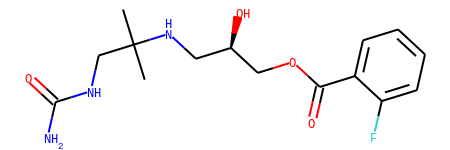

In [ ]:
m